## **Orchestrator-worker Workflow**


In [1]:
from typing_extensions import TypedDict, Literal
from langchain.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
from typing import Annotated, List
import operator
from langgraph.types import Send

In [2]:
llm = ChatOllama(model="deepseek-v3.1:671b-cloud")

In [3]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

In [4]:
# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [5]:
# Graph state
class AgentState(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [6]:
# Nodes
def orchestrator(state: AgentState):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="""Generate a plan for the report. You must return ONLY a JSON object with the following structure:
{
  "sections": [
    {
      "name": "Section Name",
      "description": "Brief description of what this section covers"
    }
  ]
}

Create 4-6 sections for the report. Return ONLY the JSON, no other text or explanation."""),
            HumanMessage(
                content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

In [7]:
def synthesizer(state: AgentState):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: AgentState):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [8]:
# Build workflow
orchestrator_worker_builder = StateGraph(AgentState)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

In [9]:
# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")

orchestrator_worker_builder.add_conditional_edges(
    source="orchestrator",
    path=assign_workers,
    path_map=["llm_call"]
)

orchestrator_worker_builder.add_edge("llm_call", "synthesizer")

orchestrator_worker_builder.add_edge("synthesizer", END)

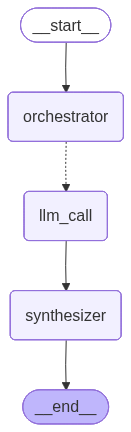

In [10]:
# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()
orchestrator_worker

In [11]:
# Invoke
response = orchestrator_worker.invoke(
    {"topic": "Create a report on LLM scaling laws"})

In [12]:
from IPython.display import Markdown
Markdown(response["final_report"])

# Introduction to LLM Scaling Laws

Scaling laws are empirical principles in artificial intelligence that describe predictable relationships between model size, dataset size, compute resources, and performance metrics in large language models (LLMs). As models and training data increase, these laws help forecast improvements in capabilities such as accuracy, fluency, and reasoning, enabling more efficient AI development.

The significance of scaling laws lies in their ability to guide resource allocation, reduce trial-and-error in model design, and set benchmarks for progress in natural language processing. They underscore the trend that larger-scale training often leads to emergent abilities, pushing the boundaries of what AI can achieve.

Key historical milestones include:

- **2017-2018**: Early observations in deep learning, such as the "Neural Scaling Laws" paper by Hestness et al., which established foundational scaling trends across various domains.
- **2020**: OpenAI's landmark paper "Scaling Laws for Neural Language Models" by Kaplan et al., which quantified scaling relationships specifically for LLMs, showing performance improvements with model parameters, data, and compute.
- **2022**: DeepMind's "Chinchilla" research, which refined scaling laws by emphasizing optimal data-to-model size ratios, leading to more efficient training of models like Chinchilla itself.
- **2023**: Continued validation and extensions, such as work on "Emergent Abilities of Large Language Models," highlighting how scaling enables new functionalities not present in smaller models.

---

## Key Mathematical Foundations

The scaling behavior of neural networks is characterized by power-law relationships across three critical resources: computational budget, dataset size, and model parameters. These relationships provide a quantitative framework to predict how performance improves as these resources are increased.

### Compute Scaling

The relationship between computational budget (measured in FLOPs, \( C \)) and model performance (loss, \( L \)) follows a power-law of the form:

\[
L(C) \propto C^{-\alpha_C}
\]

Where \( \alpha_C \) is the scaling exponent for compute. Empirical studies (e.g., from OpenAI's Scaling Laws) have found this exponent to be roughly \( \alpha_C \approx -0.05 \) to \( -0.07 \), indicating that a significant increase in compute is required for a modest reduction in loss. The optimal allocation strategy, when scaling compute, is often to increase model size (\( N \)) and dataset size (\( D \)) in balance:

\[
C \propto N D
\]

### Data Scaling

The relationship between dataset size (\( D \)) and loss is also a power-law:

\[
L(D) \propto D^{-\alpha_D}
\]

The exponent \( \alpha_D \) is typically found to be in the range of \( -0.2 \) to \( -0.3 \). This is a steeper scaling than compute, implying that increasing the amount of high-quality training data is highly effective for reducing loss, though subject to diminishing returns once the dataset becomes sufficiently large.

### Parameter Scaling

For model size, measured by the number of non-embedding parameters (\( N \)), the scaling law is:

\[
L(N) \propto N^{-\alpha_N}
\]

The exponent \( \alpha_N \) is observed to be around \( -0.07 \) to \( -0.09 \). This relatively shallow slope indicates that simply increasing the number of parameters yields diminishing performance gains unless accompanied by proportional increases in data and compute to avoid underfitting.

### The Joint Scaling Law

When scaling all three factors optimally, the overall performance can be modeled by a joint power-law:

\[
L(N, D, C) \approx \left( \frac{N_c}{N} \right)^{\alpha_N} + \left( \frac{D_c}{D} \right)^{\alpha_D} + \left( \frac{C_c}{C} \right)^{\alpha_C}
\]

Where \( N_c \), \( D_c \), and \( C_c \) are constants representing critical thresholds. In practice, these scaling relationships are interdependent. For optimal performance, the model should not be under-trained (insufficient compute/ data for a given size) or over-sized (too many parameters for the available data). The most efficient scaling occurs when these resources are increased in a balanced way, governed by the ratios of their respective exponents.

---

### Key Seminal Studies

**1. Kaplan et al., "Scaling Laws for Neural Language Models" (2020)**

This landmark paper systematically demonstrated the relationship between model scale (parameters, dataset size, and compute budget) and performance. The core finding was a power-law relationship: test loss decreases predictably as a power of the amount of compute used for training. The research established that increasing model parameters, data, and compute in concert leads to smooth, predictable improvements in performance, forming the foundational "neural scaling laws."

**2. Hoffmann et al., "Training Compute-Optimal Large Language Models" (Chinchilla, 2022)**

The Chinchilla paper challenged the sheer parameter-centric scaling of models like GPT-3. It demonstrated that for a given compute budget, performance is optimized by training a model with *fewer* parameters but on *significantly more data*. The key empirical result was a 70 billion parameter model trained on 1.4 trillion tokens outperformed a 280 billion parameter model (Gopher) trained on 300 billion tokens. This established a crucial refinement to scaling laws: optimal performance requires balancing model size and dataset size.

**3. Wei et al., "Emergent Abilities of Large Language Models" (2022)**

This study documented that certain capabilities are not present in smaller models and appear abruptly as a function of scale. These "emergent abilities," such as multi-step arithmetic, reasoning, and instruction following, were shown to be unpredictable via simple extrapolation from smaller models. This evidence highlighted that scaling doesn't just produce quantitative improvements but can lead to qualitative, phase-change-like leaps in model capability.

### Analysis of Experimental Evidence

**The Power-Law Relationship:** The primary empirical evidence from Kaplan et al. and subsequent work shows that the test loss (cross-entropy) scales as a power-law function of three key variables: the number of model parameters (N), the size of the training dataset (D), and the amount of compute used for training (C). This relationship is remarkably consistent across model architectures, suggesting it is a fundamental property of large-scale statistical estimation.

**The Compute-Optimal Frontier:** The Chinchilla study provided concrete evidence that previous scaling efforts were data-starved. It established an optimal scaling law where the model size (N) and the dataset size (D) should be scaled proportionally (approximately N ∝ D) for a fixed compute budget. The empirical results showed that violating this balance—by over-investing in parameters—leads to suboptimal performance.

**Predictable vs. Emergent Behavior:** The evidence points to a dual nature of scaling. For core metrics like loss, scaling is highly predictable. However, for specific tasks (especially those requiring reasoning), performance can exhibit sharp, emergent transitions. This suggests that while the *base capability* scales smoothly, the *expression* of complex skills has threshold effects, making the full impact of scaling difficult to forecast precisely from small-scale experiments.

---

# Practical Implications for Model Training

## Optimizing Resource Allocation

Scaling laws suggest that model performance improves predictably with increased compute, data, and model size. To optimize resource allocation:

*   **Budget-Based Scaling:** First, determine your total compute budget (e.g., GPU hours). The laws indicate that this budget should be allocated in a balanced way. A common approach is the "Chinchilla-optimal" scaling: for every doubling of model size (parameters), the training dataset size should also be doubled. Avoid the pitfall of training a large model on a relatively small dataset.
*   **Prioritize Data Quality:** When scaling the dataset, prioritize quality and diversity over sheer quantity. Cleaning and deduplicating data can be more cost-effective than gathering a larger volume of noisy data. Allocate resources for rigorous data curation.
*   **Efficient Hardware Utilization:** Invest in hardware and software infrastructure that maximizes utilization (e.g., high-performance interconnects, efficient data loaders). Wasted compute cycles due to bottlenecks are a direct loss against your scaling budget.

## Informing Model Architecture Decisions

Scaling laws provide a quantitative framework for making architectural choices.

*   **Parameter Count vs. Depth/Width:** While total parameter count is a key variable, scaling laws are largely agnostic to the specific arrangement of those parameters (depth vs. width). This provides flexibility. However, architectural innovations that improve training efficiency (e.g., better activation functions, normalization schemes) effectively give you "more performance per parameter," allowing you to achieve a target performance level with a smaller, cheaper model.
* **Testing Architectural Variants:** When evaluating a new architectural component (e.g., a new attention mechanism), the most effective test is to compare the scaling curves. Train a baseline model and the new model at several different scales (small, medium, large). If the new architecture's curve lies above the baseline's, it is a genuinely more efficient architecture.

## Guiding Training Strategies

Training dynamics are deeply intertwined with scale.

*   **Learning Rate and Batch Size Scaling:** As model size and batch size increase, the optimal learning rate often changes. Use learning rate scaling rules (e.g., linear or square root scaling with batch size) as a starting point for hyperparameter tuning at larger scales. Automated hyperparameter optimization becomes increasingly valuable for large-scale training runs.
* **Optimal Training Duration:** Scaling laws imply there is an optimal number of training steps for a given model and dataset size. Under-training leaves performance on the table, while over-training wastes compute without significant gains. Use validation loss curves to identify the point of diminishing returns.
* **Regularization and Generalization:** Larger models have a greater capacity to overfit. As you scale up, the role of regularization (e.g., dropout, weight decay) may need to be re-evaluated. Often, appropriately scaled models trained on massive datasets exhibit less overfitting, potentially reducing the need for strong regularization.

---

# Limitations and Current Challenges

## Scaling Law Assumptions

Existing scaling laws, which forecast performance improvements of AI models as a function of parameters, compute, and data, are based on several critical and potentially limiting assumptions. They often assume:

- **Smoothly scalable architectures**: That current neural network designs (e.g., the transformer) will continue to scale effectively without fundamental bottlenecks.
- **Unbounded data availability**: That high-quality, novel training data will continue to be available in the quantities required, ignoring potential exhaustion of public data sources.
- **Linear relationship with compute**: That performance improvements can be "bought" with more computational power, which may not hold if algorithmic efficiency plateaus or new, unforeseen physical limits are reached.
- **Homogeneous hardware improvements**: That hardware scaling (e.g., Moore's Law) will continue at a predictable pace, which is becoming increasingly challenging.

These assumptions are being tested as models grow, and deviations could invalidate current projections, leading to a potential performance plateau.

## Emergent Constraints

As the field of large-scale AI progresses, several emergent constraints are becoming prominent:

- **Environmental and Economic Costs**: The energy consumption and carbon footprint of training and running massive models are significant and increasingly subject to public and regulatory scrutiny. The sheer economic cost of training (e.g., tens or hundreds of millions of dollars) creates a high barrier to entry, potentially stifling innovation and concentrating power.
- **Data Scarcity and Quality**: Models are approaching the limits of publicly available, high-quality text and image data. The push for more data is leading to increased use of synthetic data or lower-quality web-scraped content, which may introduce biases, errors, and lower overall capability gains.
- **Interpretability and Safety**: The complexity and "black box" nature of models with trillions of parameters make it extremely difficult to ensure they are safe, aligned with human values, and free from harmful biases. This opacity is a fundamental constraint on deployment in high-stakes domains.
- **Infrastructure Limits**: Pushing the boundaries of scale requires bespoke, massive-scale computing infrastructure (e.g., exaflop-class supercomputers). The engineering challenges of building and reliably operating such systems at the extreme edge of current technology are non-trivial and act as a practical brake on scaling.

## Unresolved Questions

Several profound questions remain unresolved and are central to the future trajectory of the field:

1.  **Is scale sufficient for general intelligence?** Will simply making models bigger and training them on more data inevitably lead to artificial general intelligence (AGI), or are fundamental architectural or algorithmic breakthroughs required?
2.  **What are the fundamental limits of the transformer architecture?** Is the transformer the final foundational model for language, or will it be superseded by a more efficient or capable architecture as scaling continues?
3.  **How can we reliably evaluate true understanding and reasoning?** Current benchmarks are often solvable through pattern recognition and memorization. How do we create evaluations that truly measure deep understanding, reasoning, and the ability to generalize to novel situations?
4.  **What are the long-term societal impacts?** How will economies and societies adapt to the widespread deployment of highly capable AI? The long-term implications for employment, creativity, information integrity, and geopolitical stability are largely unknown.
5.  **How do we achieve robust alignment and control?** We lack a proven, scalable methodology for ensuring that superhuman AI systems reliably and safely pursue complex goals specified by humans.

---

# Future Directions and Scaling Frontiers

## Next-Generation Scaling Approaches

As artificial intelligence systems grow in complexity and application breadth, advancing scaling methodologies becomes paramount. The next evolutionary steps focus on two synergistic frontiers: multimodal integration and algorithmic efficiency.

### Multimodal Scaling

The future of scalable AI lies in transcending unimodal limitations by harnessing interconnected data types. Multimodal systems combine text, images, audio, video, and sensor data to create more holistic and context-aware models. Key developments in this area include:

- **Cross-Modal Alignment:** Creating unified embedding spaces where representations from different modalities are semantically aligned, enabling seamless translation and reasoning across data types.
- **Fusion Architectures:** Designing novel neural network topologies that effectively merge features from diverse inputs, such as transformer-based models with parallel streams for each modality.
- **Generalist Models:** Moving beyond specialized systems towards single, large-scale models capable of processing and generating multiple types of content, reducing deployment overhead and improving coherence.

### Efficiency Optimizations

As model sizes and computational demands surge, sustainable scaling necessitates a sharp focus on efficiency. Innovations aim to maintain or enhance performance while drastically reducing resource consumption.

- **Sparse Models:** Leveraging techniques like mixture-of-experts (MoE) architectures, where only subsets of a model activate for a given input, effectively increasing capacity without proportionally increasing computation.
- **Quantization and Compression:** Developing advanced methods to represent model parameters with lower precision (e.g., 8-bit or 4-bit integers) and pruning redundant weights, enabling faster inference and reduced memory footprint.
- **Hardware-Software Co-Design:** Creating specialized accelerators (e.g., TPUs, neuromorphic chips) and algorithms optimized for them, targeting energy efficiency and high-throughput processing.
- **Dynamic Computation:** Implementing adaptive mechanisms that allocate computational resources based on input complexity, allowing simpler queries to be processed faster while reserving full capacity for harder tasks.

The interplay between multimodal capabilities and efficiency gains will define the next wave of AI progress, enabling more powerful, versatile, and accessible intelligent systems.